In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing()

housing_df = pd.DataFrame(data.data, columns=data.feature_names)
housing_df["price"] = data.target

housing_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [29]:
def find_outliers_with_zscore(df, feature):

  mean = df[feature].mean()
  std = df[feature].std()

  df["z_score"] = df[feature].apply(lambda x: (x-mean)/std)
  df["is_outlier_z_score"] = df["z_score"].apply(lambda x: 1 if x > 3 else 0)

  return df

In [14]:
housing_df.describe().T

,count,mean,std,min,25%,50%,75%,max
MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
price,20640.0,2.068558,1.153956,0.149990,1.196000,1.797000,2.647250,5.000010


In [40]:
housing_df = find_outliers_with_zscore(housing_df, "price")

housing_df["is_outlier_z_score"].value_counts()

,count
is_outlier_z_score,
0,20640


### Method 2 with IQR

In [41]:
def find_outliers_IQR(df, feature):

    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 *IQR

    df["is_outlier_IQR"] = df[feature].apply(lambda x: 1 if x< lower_bound  or x > upper_bound else 0)

    return df

<Axes: xlabel='price', ylabel='Count'>

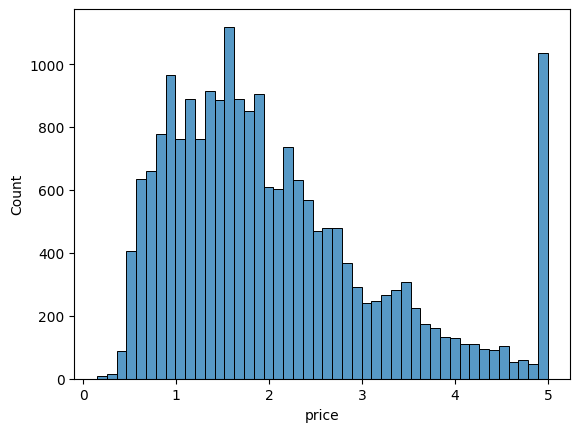

In [44]:
columns = housing_df.columns.to_list()

sns.histplot(housing_df[columns[-3]])

<Axes: xlabel='price', ylabel='Count'>

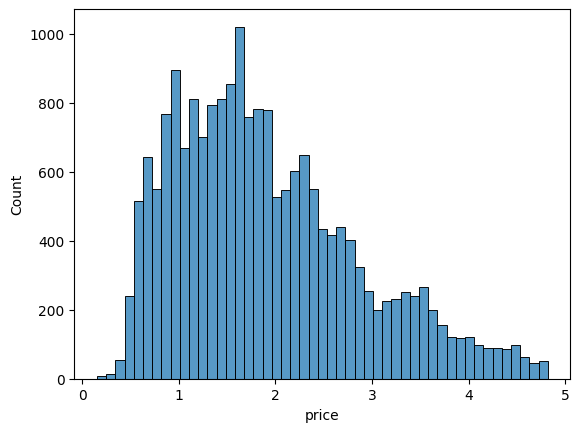

In [49]:
filtered_df = find_outliers_IQR(housing_df, "price")

filtered_df = filtered_df[filtered_df["is_outlier_IQR"] == 0]

sns.histplot(filtered_df["price"])

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

def evaluate_model(model, X, y):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  scaler = StandardScaler()

  X_scal_train = scaler.fit_transform(X_train)
  X_scal_test = scaler.fit_transform(X_test)

  model.fit(X_scal_train, y_train)
  y_pred = model.predict(X_scal_test)
  y_pred_train = model.predict(X_scal_train)

  mse_train = mean_squared_error(y_train, y_pred_train)
  mse_test = mean_squared_error(y_test, y_pred)

  print("MSE Train: ", mse_train)
  print("MSE Test: ", mse_test)
  print("R2 Test Score:", model.score(X_scal_test, y_test))

In [56]:
X, y = housing_df[columns[:-3]], housing_df["price"]

In [57]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

evaluate_model(model, X, y)

MSE Train:  0.5179331255246699
MSE Test:  0.5388649914036732
R2 Test Score: 0.5887810596909611


In [58]:
housing_df["is_outlier_IQR"].value_counts()

,count
is_outlier_IQR,
0,19569
1,1071


In [61]:
X, y = filtered_df[filtered_df.columns.to_list()[:-4]], filtered_df["price"]

In [62]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

evaluate_model(model, X, y)

MSE Train:  0.39354822521099514
MSE Test:  0.3662962316648418
R2 Test Score: 0.6039271088175664


In [63]:
housing_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price,z_score,is_outlier_z_score,is_outlier_IQR
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,2.129580,0,0
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,1.314124,0,0
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,1.258663,0,0
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,1.165072,0,0
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,1.172871,0,0


In [4]:
from scipy.stats import median_abs_deviation

median = housing_df["price"].median()
mad = median_abs_deviation(housing_df["price"], scale=1)


housing_df["z-mod"] = housing_df["price"].apply(lambda x: 0.6745 * ((x - median) / mad))

housing_df["is_outlier"] = housing_df["z-mod"].apply(lambda x: 1 if abs(x) > 3.5 else 0)

housing_df["is_outlier"].value_counts()

,count
is_outlier,
0,20640


## Real Bank Transaction Anomalies Detection

In [7]:
transaction_df = pd.read_csv("./synthetic_transactions.csv")

transaction_df.head()

,transaction_id,customer_id,transaction_amount,transaction_type,timestamp,location,ip_address
0,1,4174,38.413462,debit,2024-03-18 15:07:34.912596,Houston,192.168.191.4
1,2,4507,109.479246,credit,2025-02-01 15:07:34.912665,Miami,192.168.121.236
2,3,1860,169.979832,credit,2024-06-14 15:07:34.912672,Chicago,192.168.180.54
3,4,2294,77.628599,debit,2024-12-15 15:07:34.912676,New York,192.168.36.55
4,5,2130,117.030763,credit,2024-12-24 15:07:34.912679,New York,192.168.186.236


<Axes: xlabel='transaction_amount', ylabel='Count'>

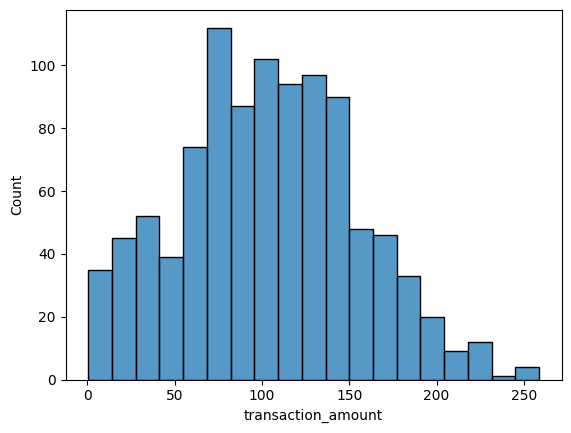

In [8]:
import seaborn as sns

sns.histplot(transaction_df["transaction_amount"])

In [64]:
transaction_df = find_outliers_IQR(transaction_df, "transaction_amount")

transaction_df["is_outlier_IQR"].value_counts()

,count
is_outlier_IQR,
0,996
1,4


In [66]:
transaction_df.head()

,transaction_id,customer_id,transaction_amount,transaction_type,timestamp,location,ip_address,is_outlier,is_outlier_IQR
0,1,4174,38.413462,debit,2024-03-18 15:07:34.912596,Houston,192.168.191.4,0,0
1,2,4507,109.479246,credit,2025-02-01 15:07:34.912665,Miami,192.168.121.236,0,0
2,3,1860,169.979832,credit,2024-06-14 15:07:34.912672,Chicago,192.168.180.54,0,0
3,4,2294,77.628599,debit,2024-12-15 15:07:34.912676,New York,192.168.36.55,0,0
4,5,2130,117.030763,credit,2024-12-24 15:07:34.912679,New York,192.168.186.236,0,0


In [68]:
transaction_df["timestamp"] = pd.to_datetime(transaction_df["timestamp"])

transaction_df["date"] = transaction_df["timestamp"].dt.date

transaction_df.head()

,transaction_id,customer_id,transaction_amount,transaction_type,timestamp,location,ip_address,is_outlier,is_outlier_IQR,date
0,1,4174,38.413462,debit,2024-03-18 15:07:34.912596,Houston,192.168.191.4,0,0,2024-03-18
1,2,4507,109.479246,credit,2025-02-01 15:07:34.912665,Miami,192.168.121.236,0,0,2025-02-01
2,3,1860,169.979832,credit,2024-06-14 15:07:34.912672,Chicago,192.168.180.54,0,0,2024-06-14
3,4,2294,77.628599,debit,2024-12-15 15:07:34.912676,New York,192.168.36.55,0,0,2024-12-15
4,5,2130,117.030763,credit,2024-12-24 15:07:34.912679,New York,192.168.186.236,0,0,2024-12-24


In [74]:
transaction_amount_frequency = transaction_df.groupby(["customer_id", "date"]).agg({"transaction_amount":"sum", "transaction_id":"count"}).reset_index().sort_values(by="customer_id", ascending=True)


transaction_amount_frequency

,customer_id,date,transaction_amount,transaction_id
0,1001,2024-06-28,103.181662,1
1,1004,2025-02-16,122.232759,1
2,1009,2024-10-11,136.617253,1
3,1011,2024-10-30,138.594100,1
4,1016,2024-11-02,94.797512,1
...,...,...,...,...
995,4986,2024-10-15,95.237746,1
996,4987,2024-05-15,164.908885,1
997,4991,2024-08-19,67.055079,1
998,4993,2024-09-27,90.287431,1
